In [1]:
from pandas import read_csv, DataFrame
from numpy import ndarray, array
from matplotlib.pyplot import figure, show, savefig
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from dslab_functions import get_variable_types, run_NB, run_KNN, CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multibar_chart, plot_bar_chart, plot_evaluation_results, plot_multiline_chart

filename = "data/class_pos_covid/data_preparation/balancing/oversampling.csv"
file_tag = "class_pos_covid"
data : DataFrame = read_csv(filename)
data.head()

,MentalHealthDays,SleepHours,WeightInKilograms,BMI,State,GeneralHealth,LastCheckupTime,RemovedTeeth,HadDiabetes,SmokerStatus,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,5.0,7.0,92.99,26.32,104.344,3,1,4,4,3,...,0,0,0,0,1,0,1,0,0,1
1,0.0,5.0,83.91,28.97,62.365,2,4,4,4,3,...,0,0,0,1,0,1,1,1,0,1
2,2.0,6.0,94.80,36.57,72.221,3,4,4,4,4,...,0,0,0,0,0,1,0,1,0,1
3,0.0,7.0,72.57,22.32,93.193,3,1,4,4,4,...,0,0,0,0,1,0,0,0,0,1
4,0.0,5.0,142.88,42.72,66.698,3,4,2,3,4,...,0,0,0,1,1,1,1,1,0,1


In [2]:
target = 'CovidPos'
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'CovidPos'], data['CovidPos']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=356615 Test#=175647
Labels=[1 0]


### NAIVE BAYES

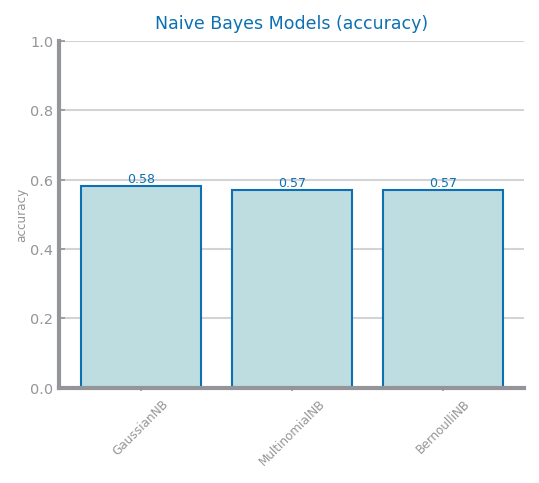

In [3]:
def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
eval_metric = "accuracy"
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}/data_classification/naive_bayes/{eval_metric}_study.png")
show()

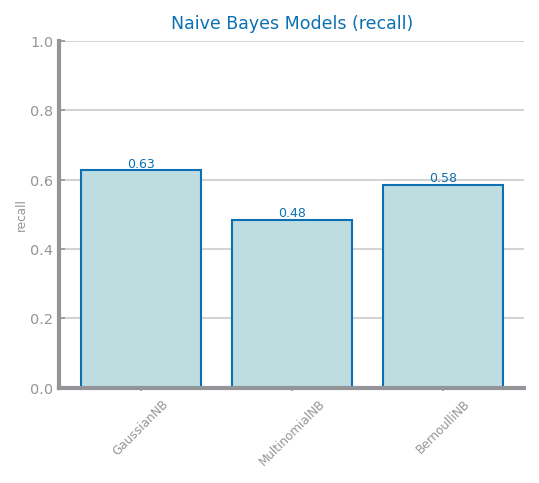

In [4]:
figure()
eval_metric = "recall"
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}/data_classification/naive_bayes/{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

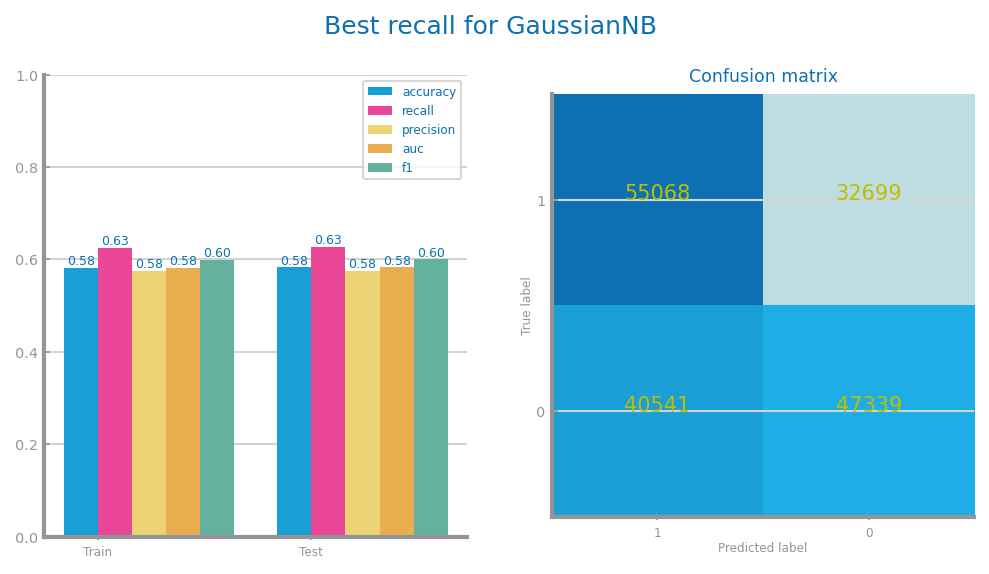

In [5]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
#list(trnY[target].unique())
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}/data_classification/naive_bayes/{params["name"]}_best_{params["metric"]}_eval.png')
show()

### KNN

In [6]:
from typing import Literal
from sklearn.neighbors import KNeighborsClassifier

KNN best with k=1 and chebyshev


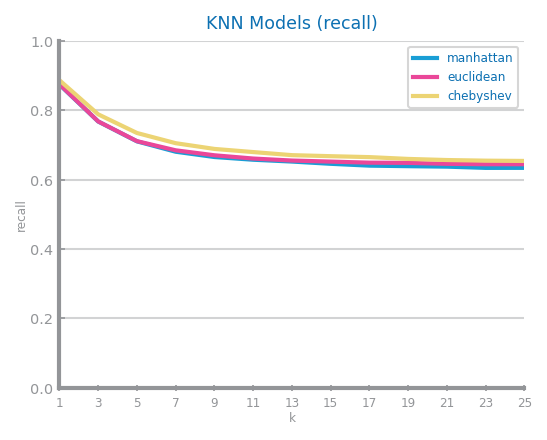

In [7]:
def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params["params"][0]} and {best_params["params"][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'images/{file_tag}/data_classification/knn/{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

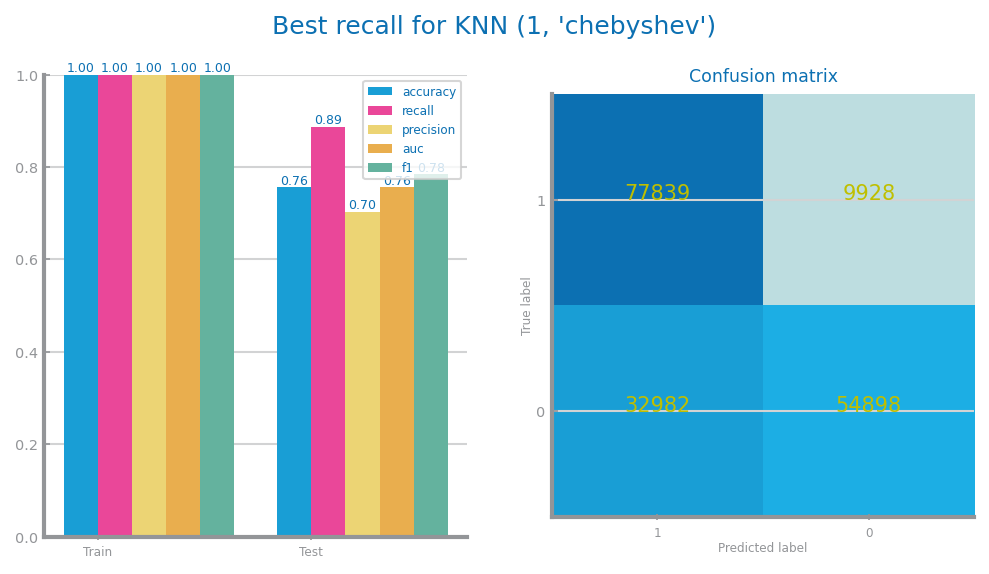

In [8]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}/data_classification/knn/{params["name"]}_best_{params["metric"]}_eval.png')
show()

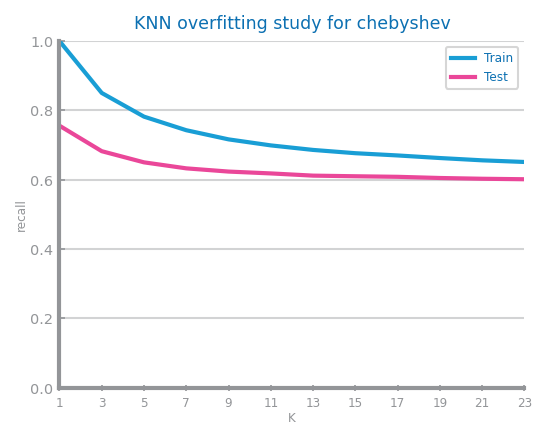

In [9]:
distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/knn/overfitting.png")
show()

### DECISION TREES

In [3]:
from typing import Literal
from sklearn.tree import DecisionTreeClassifier

DT best with gini and d=24


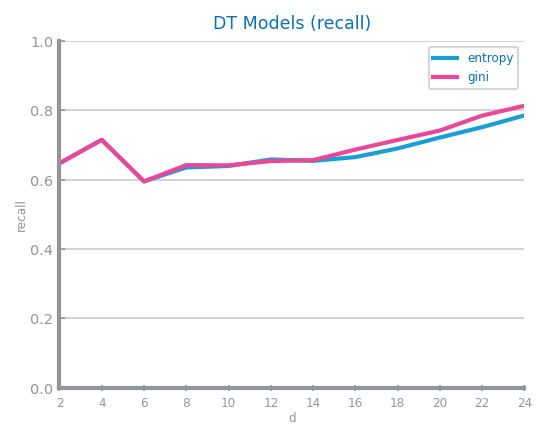

In [4]:
eval_metric = "recall"
def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f'DT best with {best_params["params"][0]} and d={best_params["params"][1]}')
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params


figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'images/{file_tag}/data_classification/decision_trees/{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

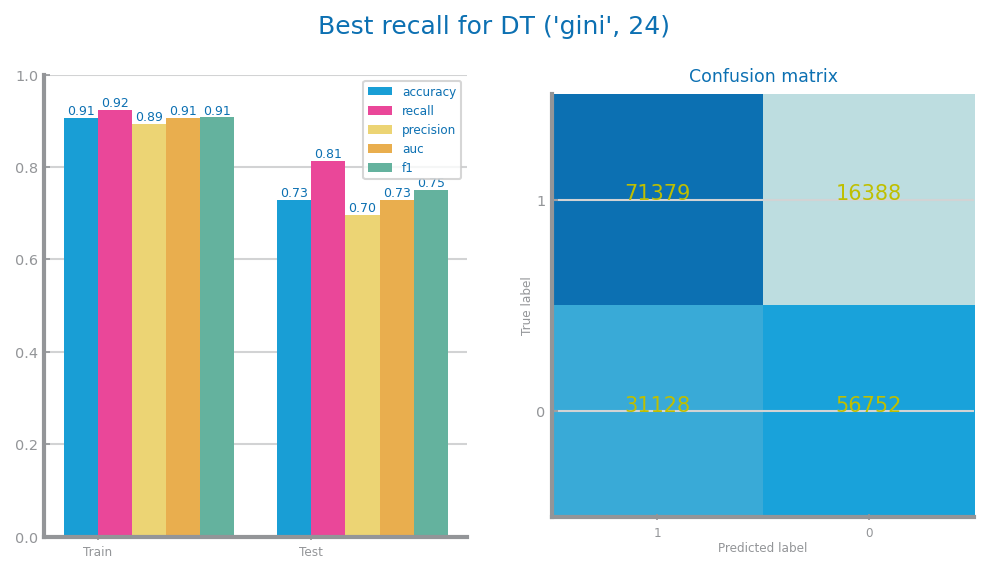

In [5]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}/data_classification/decision_trees/{params["name"]}_best_{params["metric"]}_eval.png')
show()

In [7]:
cols = data.columns.tolist()
cols.remove("CovidPos")
print(cols)

['MentalHealthDays', 'SleepHours', 'WeightInKilograms', 'BMI', 'State', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory', 'TetanusLast10Tdap', 'Sex', 'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear']


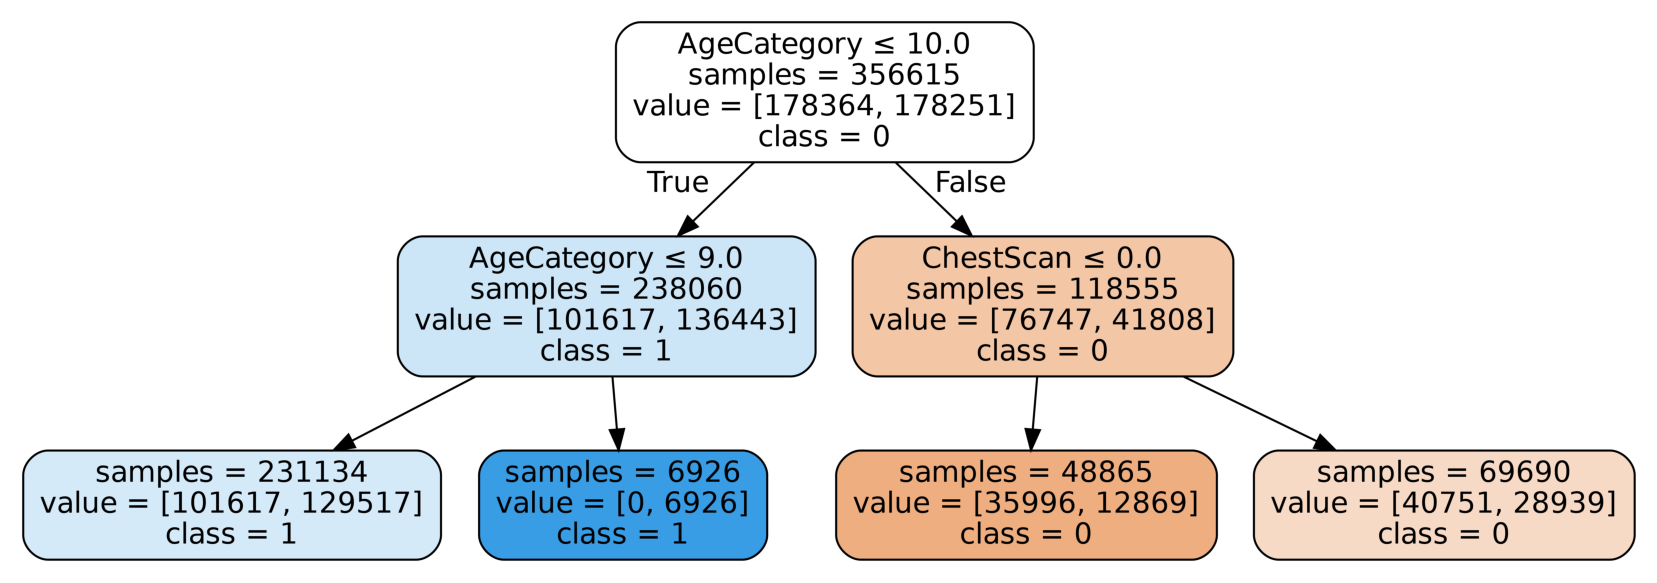

In [8]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 1
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=None,
    feature_names=cols,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
'''
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)
'''

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

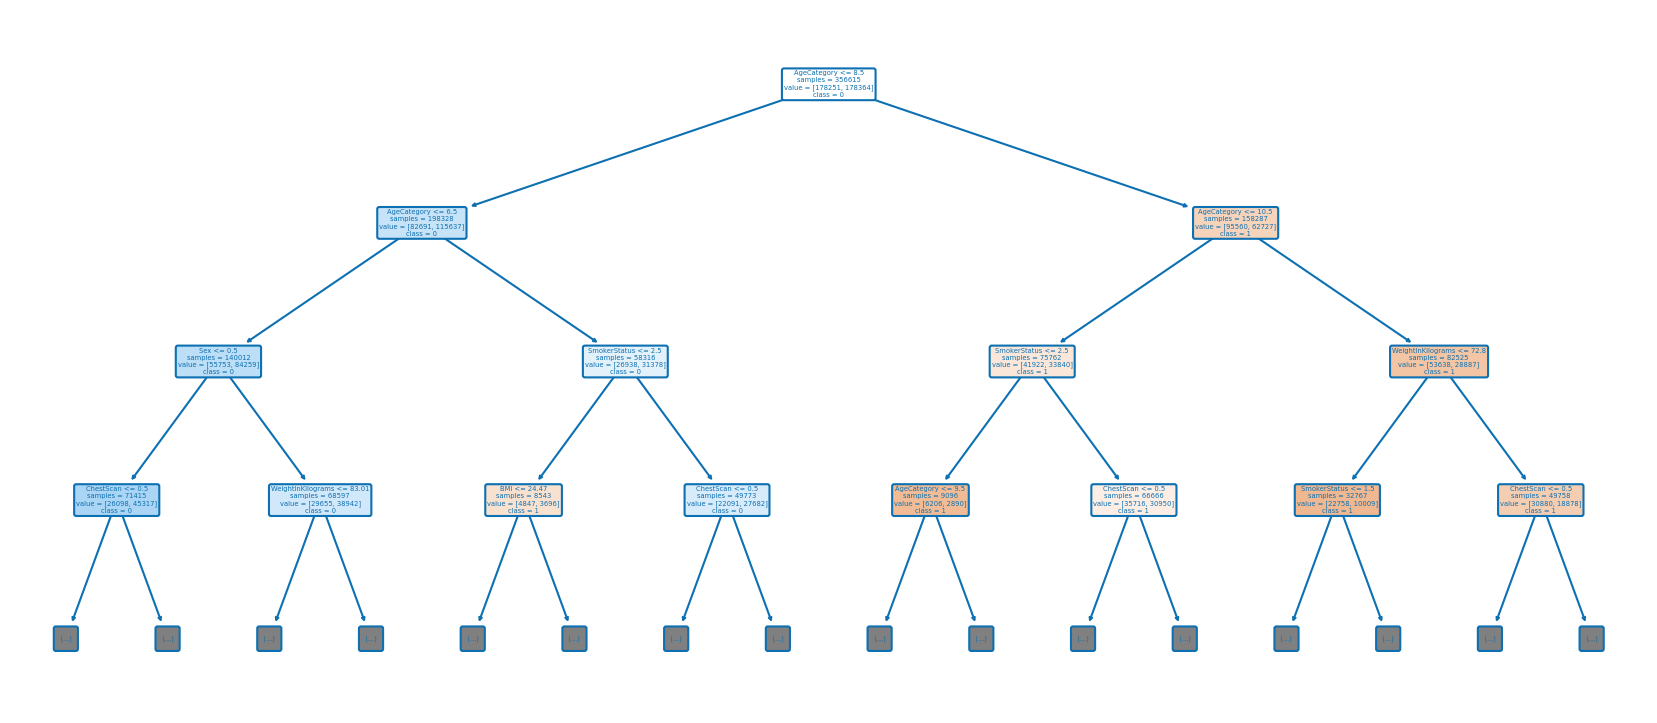

In [9]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=3,
    feature_names=cols,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(f'images/{file_tag}/data_classification/decision_trees/{tree_filename}.png')


1. BMI (0.15044374962367285)
2. State (0.12237297922094541)
3. WeightInKilograms (0.10800288541431495)
4. AgeCategory (0.07903344013024872)
5. SleepHours (0.05264750373972073)
6. MentalHealthDays (0.0503096576778521)
7. GeneralHealth (0.040361675440653916)
8. TetanusLast10Tdap (0.03571493704995541)
9. RemovedTeeth (0.03028650500952454)
10. RaceEthnicityCategory (0.02879421194570215)
11. SmokerStatus (0.025074564658923233)
12. ECigaretteUsage (0.021084923819222067)
13. LastCheckupTime (0.019463384353025998)
14. HadDiabetes (0.015960564920495173)
15. HIVTesting (0.015733993612368085)
16. PneumoVaxEver (0.015235994465562744)
17. AlcoholDrinkers (0.014486187633027775)
18. PhysicalActivities (0.014375367647990859)
19. HadAsthma (0.014056565766155263)
20. HadArthritis (0.013523801921629898)
21. HadDepressiveDisorder (0.01294232370309834)
22. FluVaxLast12 (0.012785475724093475)
23. Sex (0.009327137975518738)
24. DifficultyConcentrating (0.009106376651371106)
25. HadSkinCancer (0.0088753090791

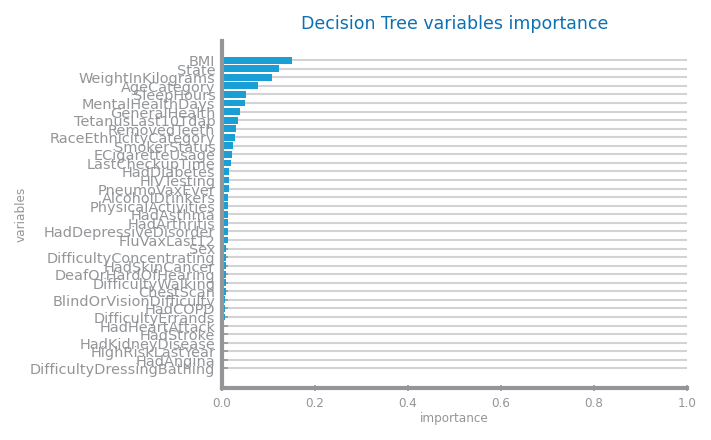

In [10]:
from numpy import argsort
from dslab_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
feature_names= cols
for f in range(len(cols)):
    elems += [cols[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/decision_trees/{eval_metric}_vars_ranking.png")

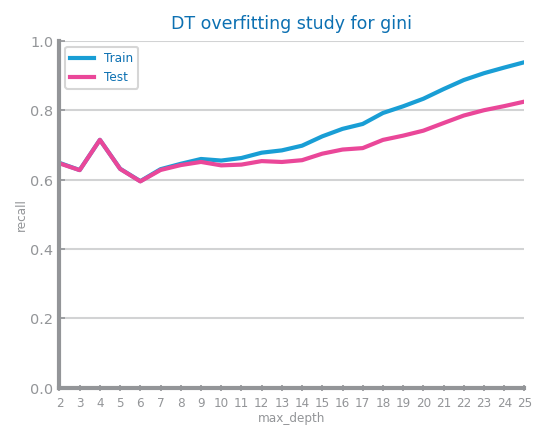

In [11]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "recall"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/decision_trees/{eval_metric}_overfitting.png")
